In [1]:
import warnings
warnings.simplefilter("ignore")
import os
srt_dir = os.getcwd()

import numpy as np
import pandas as pd
import pylab as plt
plt.close('all') # can be commented out, this just closes any previously generated graphics


#Comment next line in to CHANGE TO WHERE THE PSDM IS STORED ON YOUR MACHINE
# os.chdir('../')
import PSDM
os.chdir(srt_dir)
from scipy.integrate import quad
from scipy.interpolate import interp1d

from ecm import ecm

# Equilibrium Column Model Example
This example may take a few minutes to run, but highlights the comparison between the ECM and PSDM models. The PSDM model can take time to run depending on the number of inputs.

In [2]:
def plot_ecm(ecm_obj):
    xdata = [0] + [i for i in np.flip(ecm_obj.days_to_breakthrough) for j in range(2)] +\
            [ecm_obj.days_to_breakthrough[0]+1]
    
    cmat = np.flip(np.transpose(ecm_obj.cstore*ecm_obj.compdata.loc['MW'].values))
    
    store_obj = {}
    cmps = np.flip(ecm_obj.compdata.columns)
    for i in range(ecm_obj.n):
        ydata = [0,0] + [j for j in cmat[i] for k in range(2)]
        # print(xdata)
        # print(ydata)
    
        fnct = interp1d(xdata, ydata, fill_value='extrapolate')
        store_obj[cmps[i]] = fnct
        # plt.plot(xdata, ydata, label=cmps[i])
        
    # plt.legend()
    
    return store_obj

In [ ]:
short_example = True
if short_example:## 3 compounds
    fn = 'ECM_files/Example_ECM2y.xlsx'
    fn2 = 'ECM_files/ecm_data2y.xlsx'
else:
    ## 7 compounds ### may take several minutes to run
    fn = 'ECM_files/Example_ECM.xlsx'
    fn2 = 'ECM_files/ecm_data2.xlsx'

In [4]:
factor = 2.
duration = 6000
# duration = 11000


chem_data = PSDM.process_input_data(fn, sheet_name='Properties') 
k_data = pd.read_excel(fn, sheet_name='Kdata',index_col=0) # K & 1/n data


raw_data, column_info,\
compounds, carbons, = PSDM.process_input_file(fn,\
                                               data_sheet='data',\
                                               column_sheet='columnSpecs'
                                              )

ecm_obj = ecm(fn2, units='mass')
ecm_obj.compdata.loc['C0'] *= factor
ecm_obj.compdata.loc['Co'] *= factor
ecm_obj.run_ecm(print_results=True)

plt_results = plot_ecm(ecm_obj)

fifty_percent = ecm_obj.compdata.loc['C0']/2
print('Fifty percent breakthrough concentration (ug/L)')
print(fifty_percent.values)

# =============================================================================
# Multi Component - No Fouling    
# =============================================================================

raw_data.index = [0, duration]
raw_data *= factor

water_type = 'Organic Free'
chem_type = 'halogenated alkenes'

nr=7  #radial
nz=12 #axial
ne=3  #finite axial elements  

column = PSDM.PSDM(column_info[carbons[0]], chem_data, raw_data,\
                         nz=nz,\
                         nr=nr,\
                         ne=ne,\
                         chem_type=chem_type,\
                         water_type=water_type,\
                         k_data=k_data,\
                         solver='BDF')
    
print('Starting example multicomponent simulation\n', 'This may take several minutes')

all_results = column.run_psdm()

cmpds = ecm_obj.compdata.columns
count = 0
print(k_data)
flrt = column_info.loc['flrt'].values[0] #ml/min
k_guess = []
btd = []
pr = []
k_bounds = []
boundingRange = .30 #25% allowable
xn_test = 0.4
for i in cmpds:
    print(i)
    fiftyPerc = np.round(fifty_percent[i],2)
    halfway = all_results[i].y[all_results[i].y <= fiftyPerc]
    idx = len(halfway) - 1
    btd += [np.round(all_results[i].x[idx],2)]
    print('50%  :', np.round(all_results[i].y[idx],2),'\t', fiftyPerc)    
    print('btd  :', np.round(all_results[i].x[idx],2),'\t', np.round(ecm_obj.days_to_breakthrough[count],2))
    
    c0 = raw_data['influent'][i][0]
    peakC = np.max(all_results[i].y)
    pr += [np.round(peakC/c0,3)]
    print('peakC:', np.round(peakC/c0,3),'\t', np.round(np.diag(ecm_obj.cratio)[count],3))
    
    # estimate K
    ninetyPerc = all_results[i].y[all_results[i].y <= .95 * c0]
    ninetyP_len = len(ninetyPerc)
    
    # print(all_results[i].x[ninetyP_len+1])
    try:
        q_minus = quad(all_results[i], 0, all_results[i].x[ninetyP_len])[0] *\
                  flrt/1e3 * PSDM.min_per_day
        q_val = (c0 * flrt/1e3 * all_results[i].x[ninetyP_len] * PSDM.min_per_day - q_minus)/\
                 column_info.loc['wt'].values[0]
    except:
        q_minus = quad(all_results[i], 0, all_results[i].x[-1])[0] *\
                  flrt/1e3 * PSDM.min_per_day
        q_val = (c0 * flrt/1e3 * all_results[i].x[-1] * PSDM.min_per_day - q_minus)/\
                column_info.loc['wt'].values[0]
    
    # print(k_data[i]['K'] * c0**k_data[i]['1/n'])
    # print(q_val)
    K1 = q_val/c0**xn_test
    # print(K1)
    
    Kmolar = K1 / chem_data[i]['MW'] / (1/chem_data[i]['MW'])**(xn_test)
    
    print(Kmolar)
    k_guess += [Kmolar]
    k_bounds += [(Kmolar*(1-boundingRange), Kmolar*(1+boundingRange))]
    count+=1

k_guess += [xn_test] * len(k_guess)
k_bounds += [(.2, .6)] * len(k_bounds)
print(k_guess, btd, pr)

pr_new = [i * 1. for i in pr] # require fitting to over-estimtate of peak ratio

k_data_new = k_data * 1.

# results = ecm_obj.fit_ecm(btd, pr_new, k_guess, k_bounds, brk_weight=1e5)
results = ecm_obj.fit_ecm2(all_results, k_guess, k_bounds)

k_new = results.x[:ecm_obj.n] * chem_data.loc['MW'] * (1/chem_data.loc['MW'])**results.x[ecm_obj.n:]

k_data_new.loc['K'] = k_new
k_data_new.loc['1/n'] = results.x[ecm_obj.n:]

print(k_data_new)

column = PSDM.PSDM(column_info[carbons[0]], chem_data, raw_data,\
                         nz=nz,\
                         nr=nr,\
                         ne=ne,\
                         chem_type=chem_type,\
                         water_type=water_type,\
                         k_data=k_data_new,\
                         solver='BDF')
    
print('Starting example multicomponent simulation\n', 'This may take several minutes')

all_results2 = column.run_psdm()

['mxyl' 'oxyl' 'ethylbenzene' 'toluene' 'tetrachloroethene'
 'trichloroethene' 'dichloroethene']
days to breakthrough
[10833.53  6467.67  4523.25  1593.93  1204.55   506.87   106.56]
bvf
[1659720.42  990861.59  692972.44  244193.83  184539.74   77654.14
   16324.6 ]
usage rate (m**3/kg)
[3691.024 2203.56  1541.09   543.058  410.395  172.694   36.304]
single solute treatement capacity (mg Carbon/L water)
[ 0.167  0.305  0.246  1.173  1.413  4.354 25.241]
c store (ug/L)
[[ 10.4    18.4     9.     38.6    75.2    95.8   141.8  ]
 [  0.     26.379   9.42   38.9    75.528  95.852 141.807]
 [  0.      0.     23.224  42.365  78.753  96.303 141.859]
 [  0.      0.      0.     53.019  85.739  97.075 141.935]
 [  0.      0.      0.      0.    169.072  99.704 142.162]
 [  0.      0.      0.      0.      0.    152.069 143.986]
 [  0.      0.      0.      0.      0.      0.    172.655]]
C/C0
[[1.    1.    1.    1.    1.    1.    1.   ]
 [0.    1.434 1.047 1.008 1.004 1.001 1.   ]
 [0.    0.    2.58

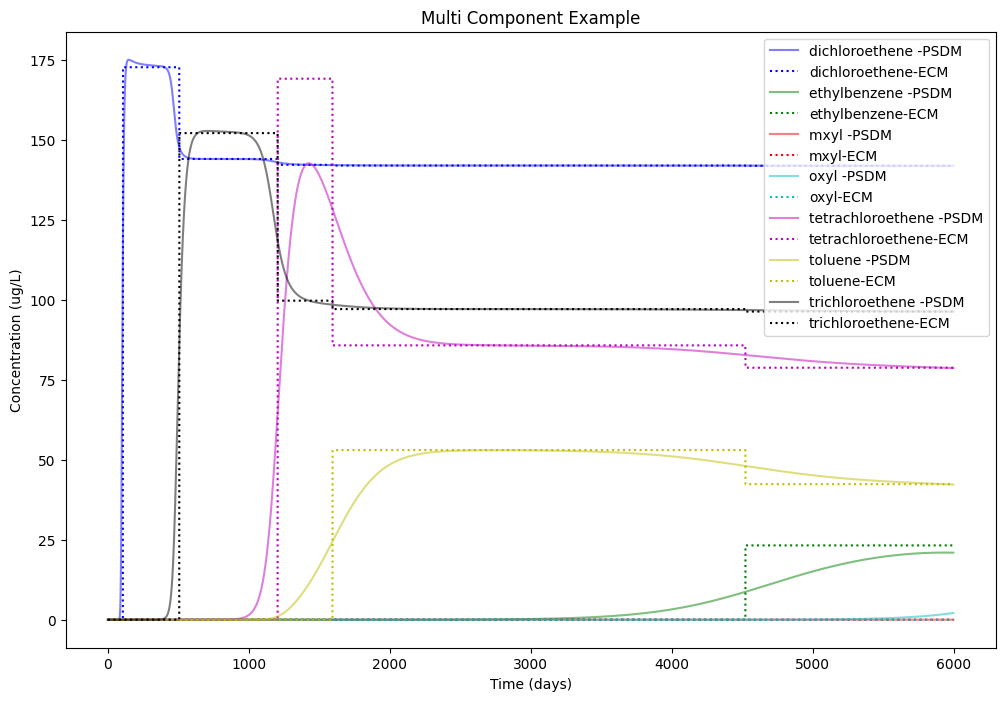

In [5]:
color = {1:'blue', 2:'g', 3:'r', 4:'c', 5:'m', 6:'y', 7:'k', 8:'brown', 
         9:'crimson', 10:'darkblue', 11:'fucshia', 12:'grey', 13:'gold', 
         14:'chartreuse', 15:'khaki', 16:'orchid', 17:'silver'} ### forces colormap
    
count = 1
plt.figure(figsize=(12,8))
for i in all_results.keys():
    idx = np.arange(0, np.max(all_results[i].x))
    try:
        plt.plot(idx, all_results[i](idx), color=color[count], 
                label=(i+' -PSDM'), alpha=0.5
                )
    except:
        pass
    
    try:
        plt.plot(idx, plt_results[i](idx), color=color[count],
                    label=(i+'-ECM'), linestyle=':')
    except:
        pass
    
    # try:
    #     # idx = all_results2[i].x
    #     plt.plot(idx, all_results2[i](idx), color=color[count], 
    #           label=(i+' -ECM fit'), linestyle='--',
    #           )
    # except:
    #     pass    

    count += 1
    
plt.legend(loc='upper right')
plt.title('Multi Component Example')
plt.ylabel('Concentration (ug/L)')
plt.xlabel('Time (days)')
file_name = '-'.join(compounds)+'_ECM.png'
if False:
    plt.savefig(file_name, dpi=300)
# plt.close()